In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [6]:
import glob
glob.glob("drive/My Drive/Colab Notebooks/melon_music_neg_sample_v2.csv")

['drive/My Drive/Colab Notebooks/melon_music_neg_sample_v2.csv']

In [29]:
df_meta = pd.read_csv('drive/My Drive/Colab Notebooks/Meta_v1.csv')

In [34]:
import json
with open('drive/My Drive/Colab Notebooks/new_idx_dict.json', 'r') as f:
  new_idx_dict = json.loads(f.read())

with open('drive/My Drive/Colab Notebooks/new_tag_id_dict.json', 'r') as f:
  new_tag_id_dict = json.loads(f.read())

In [36]:
tag2tag_id = new_tag_id_dict
tag_id2tag = {idx: tag for tag, idx in new_tag_id_dict.items() }

In [37]:
song_id2new_id = new_idx_dict
new_id2song_id = {idx: song_id for song_id, idx in new_idx_dict.items() }

In [39]:
# new_id2song_id

In [9]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/melon_music_neg_sample_v2.csv')

In [10]:
df = df.sample(frac=1, random_state=42)

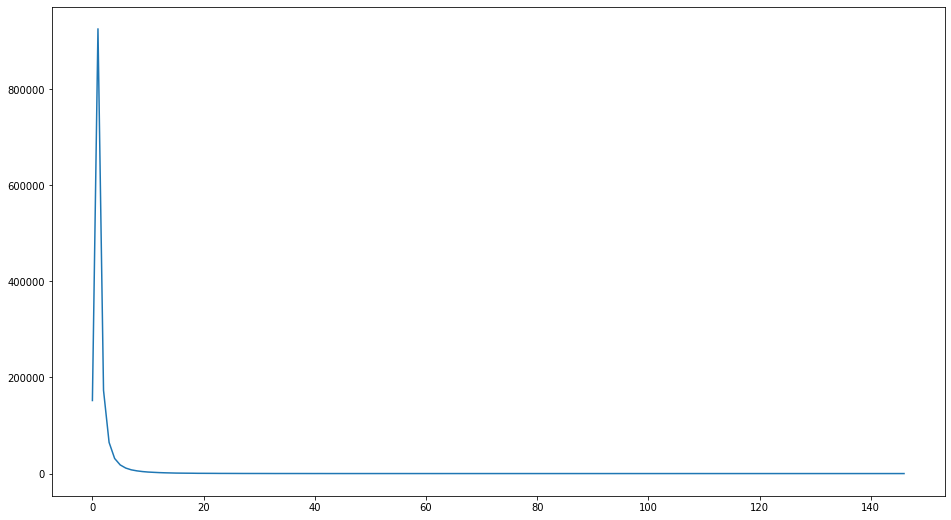

In [125]:
df.freq.value_counts().sort_index().plot(figsize=(16,9))

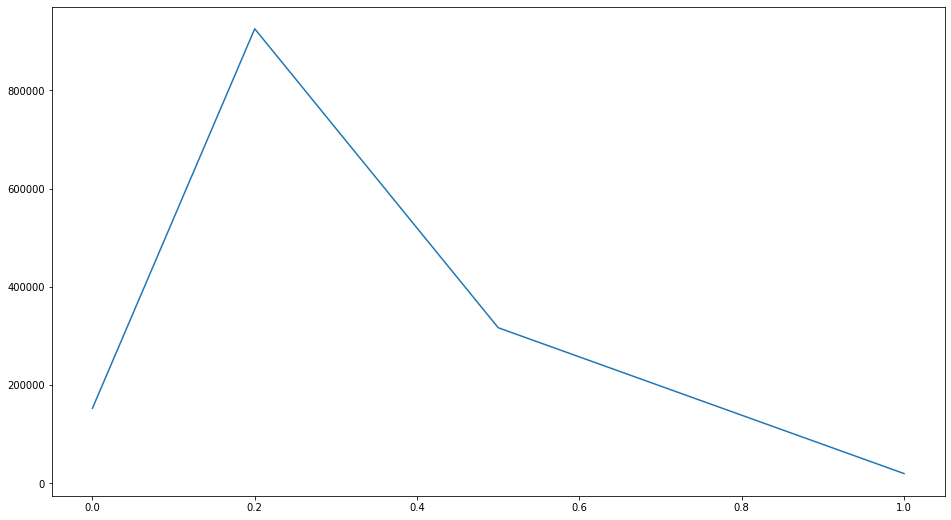

In [126]:
df.freq2.value_counts().sort_index().plot(figsize=(16,9))

In [11]:
x = df[["tag_id", "music_id"]].values
y = df["freq2"].values

In [12]:
x.shape, y.shape

((1412835, 2), (1412835,))

In [15]:
train_indices = int(0.8 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [16]:
x_train.shape

(1130268, 2)

In [17]:
tag_count = 1382
music_count = 69888

In [88]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_tags, num_musics, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_tags = num_tags
        self.num_musics = num_musics
        self.embedding_size = embedding_size
        self.tag_embedding = layers.Embedding(
            num_tags,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.tag_bias = layers.Embedding(num_tags, 1)
        self.music_embedding = layers.Embedding(
            num_musics,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.music_bias = layers.Embedding(num_musics, 1)

    def call(self, inputs):
        tag_vector = self.tag_embedding(inputs[:, 0])
        tag_bias = self.tag_bias(inputs[:, 0])
        music_vector = self.music_embedding(inputs[:, 1])
        music_bias = self.music_bias(inputs[:, 1])
        dot_tag_music = tf.tensordot(tag_vector, music_vector, 2)
        x = dot_tag_music + tag_bias + music_bias
        return tf.nn.sigmoid(x)


model = RecommenderNet(tag_count, music_count, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(lr=0.001)
)

In [107]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,
    epochs=1,
    verbose=1,
    validation_data=(x_val, y_val),
)

2208/2208 [==============================] - 40s 18ms/step - loss: 0.6008 - val_loss: 0.6271


In [90]:
model.summary()

Model: "recommender_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  69100     
_________________________________________________________________
embedding_13 (Embedding)     multiple                  1382      
_________________________________________________________________
embedding_14 (Embedding)     multiple                  3494400   
_________________________________________________________________
embedding_15 (Embedding)     multiple                  69888     
Total params: 3,634,770
Trainable params: 3,634,770
Non-trainable params: 0
_________________________________________________________________


In [97]:
def get_top_music_by_tag(tag, model, k=10, df_meta=df_meta):
  if tag2tag_id.get(tag) == None: return "No Tag"

  target_tag_id = tag2tag_id.get(tag)
  inputs = np.vstack(([[target_tag_id] * music_count], [*range(music_count)])).T

  preds= model.predict(inputs).flatten()
  top_k =preds.argsort()[(-1*k):][::-1]
  
  recommended_music_ids = [
    int(new_id2song_id.get(x)) 
    for x in top_k
  ]
  top_song_names = df_meta[df_meta.id.isin(recommended_music_ids)][['artist_name_basket','song_name']].values
  return top_song_names

In [110]:
%time get_top_music_by_tag("따뜻함", model, k=10)

CPU times: user 2.67 s, sys: 191 ms, total: 2.86 s
Wall time: 1.77 s


array([["['케이윌']", 'Love Blossom (러브블러썸)'],
       ["['백예린']", 'Bye bye my blue'],
       ["['Alice Hart']", 'Shadow On The Wall'],
       ["['아이유']", '밤편지'],
       ["['에일리']", '첫눈처럼 너에게 가겠다'],
       ["['옥상달빛']", '수고했어, 오늘도'],
       ["['Crush']", '어떻게 지내'],
       ["['Coldplay']", 'The Scientist'],
       ["['이준호']", '퇴근버스'],
       ["['우효']", 'Vineyard (빈야드)']], dtype=object)

In [111]:
%time get_top_music_by_tag("해외일렉트로니카", model, k=10)

CPU times: user 2.63 s, sys: 177 ms, total: 2.81 s
Wall time: 1.73 s


array([["['백아연']", '쏘쏘'],
       ["['임창정']", '내가 저지른 사랑'],
       ["['Karina']", 'Slow Motion (Album Version)'],
       ["['Hoody (후디)']", 'Like You'],
       ["['정미애']", '꿀맛'],
       ["['offonoff (오프온오프)']", 'Cigarette (Feat. Tablo, MISO)'],
       ["['테스 (Tess)']", '다시 시작할 수 없겠지'],
       ["['업라이트 (Upright)']", '비가 내렸어 (Vocal by 스티브언니)'],
       ["['아이유']", '금요일에 만나요 (Feat. 장이정 Of HISTORY)'],
       ["['로꼬', '유주 (여자친구)']", '우연히 봄']], dtype=object)

In [120]:
%time get_top_music_by_tag("색다른", model, k=10)

CPU times: user 2.67 s, sys: 209 ms, total: 2.88 s
Wall time: 1.79 s


array([["['스웨덴세탁소']", '목소리 (Feat. 정기고)'],
       ["['정키']", '잊혀지다 (Feat. 양다일)'],
       ["['Music Shower']", 'Soul Nights'],
       ["['김동률']", '답장'],
       ["['바이브']", '오래오래'],
       ["['OuiOui (위위)']", '니 생각 (Feat. Wilcox)'],
       ["['ATHEW']", 'New York'],
       ["['옥상달빛']", '수고했어, 오늘도'],
       ["['어반자카파']", '널 사랑하지 않아'],
       ["['박효신']", '눈의 꽃']], dtype=object)